# 📊 Sibling Execution Pattern Analysis

This notebook investigates whether contextual metrics — such as um (upperstream microservices), system load and call rate (MCR) — differ between concurrent and sequential executions of sibling microservices.

In [4]:
import pandas as pd
import os
import glob

## Sibling Pairs Statistics
Analyze sibling pair CSVs to identify and display the top 3 sequential-only, concurrent-only, and mixed-execution patterns, filtering out invalid values.

In [32]:
def contains_unwanted_values(row):
    """Check if any of um, dm1, dm2 contains '(?' or 'unknown' (case-insensitive)"""
    return any("(?" in str(val) or "unknown" in str(val).lower() for val in [row['um'], row['dm1'], row['dm2']])

def print_table(title, headers, rows, total_count):
    print(f"\n🔹 {title} ({total_count} total)")
    print("  ".join(f"{h:<14}" for h in headers))
    print("  ".join("-" * 14 for _ in headers))
    for row in rows[:3]:
        print("  ".join(f"{str(row.get(h, '')):<14}" for h in headers))

def analyze_sibling_pairs():
    folder_path = "output/siblings"
    if not os.path.exists(folder_path):
        print(f"Error: Directory {folder_path} does not exist")
        return

    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    only_sequential = []
    only_concurrent = []
    mixed_patterns = []
    clean_mixed_patterns = []

    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            if 'execution_order' not in df.columns:
                continue

            um = df['um'].iloc[0] if 'um' in df.columns else 'UNKNOWN'
            dm1 = df['dm1'].iloc[0] if 'dm1' in df.columns else 'UNKNOWN'
            dm2 = df['dm2'].iloc[0] if 'dm2' in df.columns else 'UNKNOWN'

            concurrent_count = sum(df['execution_order'] == 'concurrent')
            sequential_count = sum(df['execution_order'] == 'sequential')
            total_count = len(df)

            record = {
                'um': um,
                'dm1': dm1,
                'dm2': dm2,
                'num_concurrent': concurrent_count,
                'num_sequential': sequential_count,
                'total_observations': total_count
            }

            if concurrent_count > 0 and sequential_count == 0:
                only_concurrent.append(record)
            elif sequential_count > 0 and concurrent_count == 0:
                only_sequential.append(record)
            elif concurrent_count > 0 and sequential_count > 0:
                mixed_patterns.append(record)
                if not contains_unwanted_values(record):
                    clean_mixed_patterns.append(record)

        except Exception as e:
            print(f"Error processing {csv_file}: {e}")

    # Sort by counts
    only_sequential.sort(key=lambda x: x['num_sequential'], reverse=True)
    only_concurrent.sort(key=lambda x: x['num_concurrent'], reverse=True)
    mixed_patterns.sort(key=lambda x: x['total_observations'], reverse=True)
    clean_mixed_patterns.sort(key=lambda x: x['total_observations'], reverse=True)

    # Display results
    print_table(
        "Top 3 Sibling Pairs with Only Sequential Patterns",
        ["um", "dm1", "dm2", "num_sequential"],
        only_sequential,
        len(only_sequential)
    )

    print_table(
        "Top 3 Sibling Pairs with Only Concurrent Patterns",
        ["um", "dm1", "dm2", "num_concurrent"],
        only_concurrent,
        len(only_concurrent)
    )

    print_table(
        "Top 3 Mixed Execution Patterns",
        ["um", "dm1", "dm2", "num_concurrent", "num_sequential", "total_observations"],
        mixed_patterns,
        len(mixed_patterns)
    )

    print_table(
        "Top 3 Clean Mixed Execution Patterns (no (?) or unknown)",
        ["um", "dm1", "dm2", "num_concurrent", "num_sequential", "total_observations"],
        clean_mixed_patterns,
        len(clean_mixed_patterns)
    )

# Run the analysis
analyze_sibling_pairs()


🔹 Top 3 Sibling Pairs with Only Sequential Patterns (17090 total)
um              dm1             dm2             num_sequential
--------------  --------------  --------------  --------------
MS_63670        MS_53745        MS_63670        47835         
MS_63670        MS_23205        MS_63670        30237         
MS_63670        MS_29680        MS_63670        28560         

🔹 Top 3 Sibling Pairs with Only Concurrent Patterns (1739 total)
um              dm1             dm2             num_concurrent
--------------  --------------  --------------  --------------
MS_71956        MS_25272        MS_56926        132           
MS_71956        MS_10105        MS_25272        118           
MS_71956        MS_10105        MS_47788        114           

🔹 Top 3 Mixed Execution Patterns (3288 total)
um              dm1             dm2             num_concurrent  num_sequential  total_observations
--------------  --------------  --------------  --------------  --------------  -----------

Among the clean mixed-execution sibling pairs, we select two representative pairs for further analysis.

### 1. Mixed Pattern with Minimal Concurrency
- **File**: `sibling_MS_40123_MS_59532.csv`
- **Observations**: 17,254 (28 concurrent, 17,226 sequential)
    ```
    um               concurrent  sequential
    MS_13853                  0        1698
    MS_25766                  0           1
    MS_5897                  28       15527
    ```

### 2. Mixed Pattern with Significant Concurrency
- **File**: `sibling_MS_30541_MS_3533.csv`
- **Observations**: 11,776 (760 concurrent, 11,016 sequential)
- Contingency Table (after removing categories with fewer than 10 total observations):
    ```
    execution_order  concurrent  sequential
    um                                     
    MS_29421                  4         910
    MS_31205                  0         260
    MS_45073                  0          22
    MS_52394                232        8627
    MS_60503                  4         151
    MS_9638                 514        1024
    ```

## Contextual-related analysis: Mixed Pattern with Minimal Concurrency
- **File**: `sibling_MS_40123_MS_59532.csv`
- **Observations**: 17,254 (28 concurrent, 17,226 sequential)
    ```
    um               concurrent  sequential
    MS_13853                  0        1698
    MS_25766                  0           1
    MS_5897                  28       15527
    ```

### Parent
The chi-square test of independence is not suitable for this sibling pairs due to very low counts in some categories, which violate the assumptions of the test. Given it is a 2x2 table, we run Fisher’s Exact Test:
	•	Used correctly due to small cell counts (especially 0 in concurrent + MS_13853).
	•	p = 0.106 → not significant, so no strong evidence that execution pattern depends on the um.

In [11]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Data for the table
um_concurrent = 0
um_sequential = 1698
non_um_concurrent = 28
non_um_sequential = 15527

# Create the contingency table
contingency_table = np.array([[um_concurrent, non_um_concurrent], 
                              [um_sequential, non_um_sequential]])

# Print the table
print("Contingency Table:")
print(pd.DataFrame(contingency_table, 
                   index=['Concurrent', 'Sequential'],
                   columns=['um present (MS_13853)', 'NON-um (MS_5897)']))

# Calculate row and column totals
row_totals = contingency_table.sum(axis=1)
col_totals = contingency_table.sum(axis=0)
total = contingency_table.sum()

print("\nRow totals:", row_totals)
print("Column totals:", col_totals)
print("Total observations:", total)

# Calculate proportions
print("\nProportion of 'um' in concurrent execution:", um_concurrent / row_totals[0])
print("Proportion of 'um' in sequential execution:", um_sequential / row_totals[1])

# Fisher's exact test
# This is appropriate when some cells have very low counts (like 0)
oddsratio, p_value = stats.fisher_exact(contingency_table)
print("\nFisher's Exact Test:")
print(f"Odds ratio: {oddsratio:.6f}")
print(f"p-value: {p_value:.6f}")

# Interpret results
alpha = 0.05
if p_value < alpha:
    print(f"The p-value {p_value:.6f} is less than {alpha}, suggesting a significant association between 'um' and execution pattern.")
else:
    print(f"The p-value {p_value:.6f} is greater than {alpha}, suggesting no significant association between 'um' and execution pattern.")

# For rare events, we can also use the binomial test
# Calculate the overall rate of "um"
overall_um_rate = col_totals[0] / total
print("\nOverall 'um' rate:", overall_um_rate)

# Expected "um"s in concurrent execution under null hypothesis
expected_um_concurrent = overall_um_rate * row_totals[0]
print("Expected 'um's in concurrent execution:", expected_um_concurrent)

# Binomial test - using compatible method for different scipy versions
try:
    # Try newer scipy version method
    from scipy.stats import binomtest
    result = binomtest(um_concurrent, n=row_totals[0], p=overall_um_rate, alternative='two-sided')
    binom_p_value = result.pvalue
except ImportError:
    # If not available, use another approach
    # Calculate p-value manually using binomial probability mass function
    from scipy.stats import binom
    # P-value for binomial test is the probability of observing a result as extreme or more extreme
    # than the observed value, under the null hypothesis
    if um_concurrent <= expected_um_concurrent:
        # Left-tail probability (including observed)
        p_left = binom.cdf(um_concurrent, row_totals[0], overall_um_rate)
        # Right-tail probability for symmetric two-sided test
        p_right = 1 - binom.cdf(row_totals[0] - um_concurrent - 1, row_totals[0], 1 - overall_um_rate)
        binom_p_value = min(1.0, 2.0 * min(p_left, p_right))
    else:
        # Right-tail probability (including observed)
        p_right = 1 - binom.cdf(um_concurrent - 1, row_totals[0], overall_um_rate)
        # Left-tail probability for symmetric two-sided test 
        p_left = binom.cdf(row_totals[0] - um_concurrent, row_totals[0], 1 - overall_um_rate)
        binom_p_value = min(1.0, 2.0 * min(p_left, p_right))

print("\nExact Binomial Test:")
print(f"p-value: {binom_p_value:.6f}")

# Interpret binomial test results
if binom_p_value < alpha:
    print(f"The p-value {binom_p_value:.6f} is less than {alpha}, suggesting the proportion of 'um' in concurrent execution is significantly different from the overall rate.")
else:
    print(f"The p-value {binom_p_value:.6f} is greater than {alpha}, suggesting the proportion of 'um' in concurrent execution is not significantly different from the overall rate.")


Contingency Table:
            um present (MS_13853)  NON-um (MS_5897)
Concurrent                      0                28
Sequential                   1698             15527

Row totals: [   28 17225]
Column totals: [ 1698 15555]
Total observations: 17253

Proportion of 'um' in concurrent execution: 0.0
Proportion of 'um' in sequential execution: 0.098577648766328

Fisher's Exact Test:
Odds ratio: 0.000000
p-value: 0.106252
The p-value 0.106252 is greater than 0.05, suggesting no significant association between 'um' and execution pattern.

Overall 'um' rate: 0.09841766649278387
Expected 'um's in concurrent execution: 2.7556946617979485

Exact Binomial Test:
p-value: 0.106529
The p-value 0.106529 is greater than 0.05, suggesting the proportion of 'um' in concurrent execution is not significantly different from the overall rate.


✅ Conclusion:

There’s no statistically significant association between um = MS_13853 and execution pattern (concurrent vs. sequential), based on both Fisher’s and Binomial tests.

This is a good example of validating whether the absence of MS_13853 in one condition (concurrent) is meaningful — and the answer here is: not statistically.

### System load


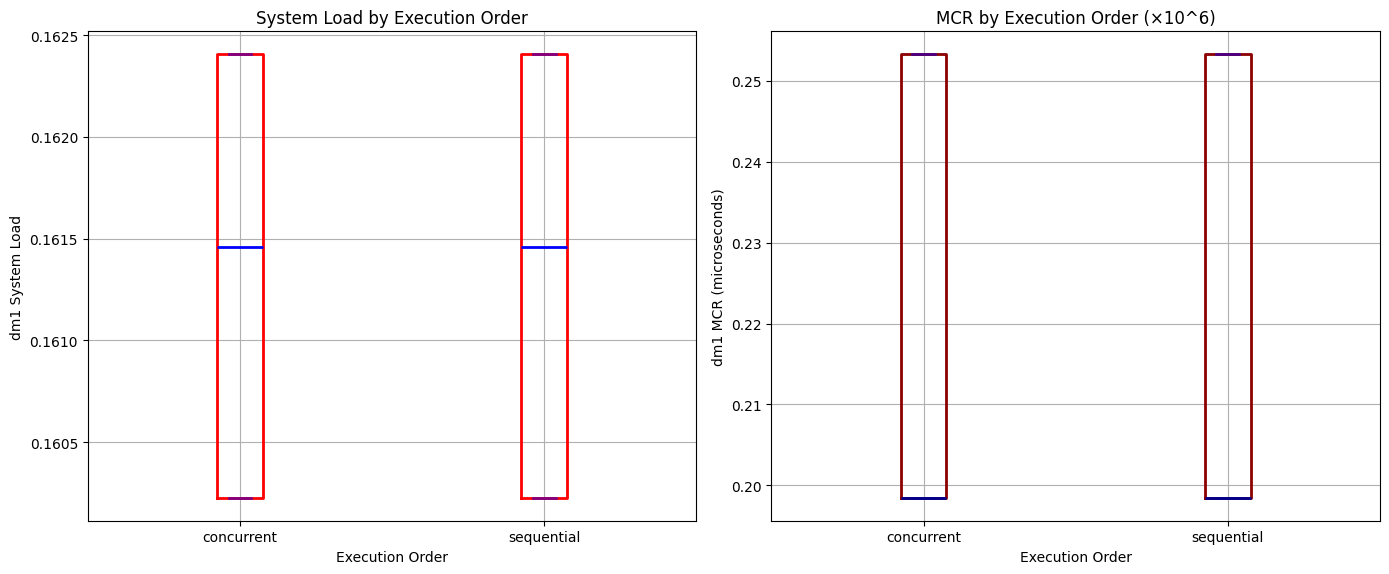

System Load Averages:
Concurrent: 0.161425
Sequential: 0.161434
System Load Mann-Whitney U p-value: 9.0776e-01
Conclusion: No significant difference in system load between concurrent and sequential executions.

MCR Averages:
Concurrent: 2.187054e-07 (or 0.218705 microseconds)
Sequential: 2.183015e-07 (or 0.218301 microseconds)
MCR Mann-Whitney U p-value: 7.7786e-01
Conclusion: No significant difference in MCR between concurrent and sequential executions.

=== Time Lag Analysis ===
Overall Average System Lag: 28717.631339
Overall Average MCR Lag: 28717.631339


In [3]:
import pandas as pd
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

# Load your data
# df = pd.read_csv("output/contextual_MS_13853.csv")
df = pd.read_csv("output/contextual_MS_9638.csv")
# df = pd.read_csv("output/contextual_MS_52394.csv")

# Convert fields to numeric, handle missing values
df['dm1_cpu'] = pd.to_numeric(df['dm1_cpu'], errors='coerce')
df['dm1_memory'] = pd.to_numeric(df['dm1_memory'], errors='coerce')
df['dm1_mcr'] = pd.to_numeric(df['dm1_mcr'], errors='coerce')
df['dm1_system_lag'] = pd.to_numeric(df['dm1_system_lag'], errors='coerce')
df['dm1_mcr_lag'] = pd.to_numeric(df['dm1_mcr_lag'], errors='coerce')

# Compute system load
df['dm1_system_load'] = 0.7 * df['dm1_cpu'] + 0.3 * df['dm1_memory']

# Scale up the MCR values for better visualization
scaling_factor = 10**6  # Scale by a million (convert to microseconds)
df['dm1_mcr_scaled'] = df['dm1_mcr'] * scaling_factor

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: System Load boxplot with custom colors
boxprops1 = dict(linestyle='-', linewidth=2, color='red')
medianprops1 = dict(linestyle='-', linewidth=2, color='blue')
whiskerprops1 = dict(linestyle='-', linewidth=2, color='green')
capprops1 = dict(linestyle='-', linewidth=2, color='purple')
flierprops1 = dict(marker='o', markerfacecolor='orange', markersize=8)

df.boxplot(column='dm1_system_load', by='execution_order', ax=axes[0],
           boxprops=boxprops1, medianprops=medianprops1, 
           whiskerprops=whiskerprops1, capprops=capprops1, flierprops=flierprops1)
axes[0].set_title("System Load by Execution Order")
axes[0].set_xlabel("Execution Order")
axes[0].set_ylabel("dm1 System Load")

# Plot 2: MCR boxplot with custom colors
boxprops2 = dict(linestyle='-', linewidth=2, color='darkred')
medianprops2 = dict(linestyle='-', linewidth=2, color='darkblue')
whiskerprops2 = dict(linestyle='-', linewidth=2, color='darkgreen')
capprops2 = dict(linestyle='-', linewidth=2, color='indigo')
flierprops2 = dict(marker='o', markerfacecolor='darkorange', markersize=8)

df.boxplot(column='dm1_mcr_scaled', by='execution_order', ax=axes[1],
           boxprops=boxprops2, medianprops=medianprops2, 
           whiskerprops=whiskerprops2, capprops=capprops2, flierprops=flierprops2)
axes[1].set_title("MCR by Execution Order (×10^6)")
axes[1].set_xlabel("Execution Order")
axes[1].set_ylabel("dm1 MCR (microseconds)")

# Remove the overall title that boxplot adds by default
plt.suptitle("")
plt.tight_layout()
plt.show()

# System Load Analysis
df_load = df.dropna(subset=['dm1_system_load', 'execution_order'])
concurrent_load = df_load[df_load['execution_order'] == 'concurrent']['dm1_system_load']
sequential_load = df_load[df_load['execution_order'] == 'sequential']['dm1_system_load']

# Print average values
print("System Load Averages:")
print(f"Concurrent: {concurrent_load.mean():.6f}")
print(f"Sequential: {sequential_load.mean():.6f}")

# Mann–Whitney U Test for System Load
stat_load, p_load = mannwhitneyu(concurrent_load, sequential_load, alternative='two-sided')
print(f"System Load Mann-Whitney U p-value: {p_load:.4e}")
if p_load < 0.05:
    print("Conclusion: System load differs significantly between concurrent and sequential executions.")
else:
    print("Conclusion: No significant difference in system load between concurrent and sequential executions.")

# MCR Analysis
df_mcr = df.dropna(subset=['dm1_mcr', 'execution_order'])
concurrent_mcr = df_mcr[df_mcr['execution_order'] == 'concurrent']['dm1_mcr']
sequential_mcr = df_mcr[df_mcr['execution_order'] == 'sequential']['dm1_mcr']

# Print average values in scientific notation
print("\nMCR Averages:")
print(f"Concurrent: {concurrent_mcr.mean():.6e} (or {concurrent_mcr.mean()*scaling_factor:.6f} microseconds)")
print(f"Sequential: {sequential_mcr.mean():.6e} (or {sequential_mcr.mean()*scaling_factor:.6f} microseconds)")

# Mann–Whitney U Test for MCR
stat_mcr, p_mcr = mannwhitneyu(concurrent_mcr, sequential_mcr, alternative='two-sided')
print(f"MCR Mann-Whitney U p-value: {p_mcr:.4e}")
if p_mcr < 0.05:
    print("Conclusion: MCR differs significantly between concurrent and sequential executions.")
else:
    print("Conclusion: No significant difference in MCR between concurrent and sequential executions.")

# Time Lag Analysis - just overall averages
print("\n=== Time Lag Analysis ===")

# System Lag - overall average
system_lag_avg = df['dm1_system_lag'].mean()
print(f"Overall Average System Lag: {system_lag_avg:.6f}")

# MCR Lag - overall average
mcr_lag_avg = df['dm1_mcr_lag'].mean()
print(f"Overall Average MCR Lag: {mcr_lag_avg:.6f}")

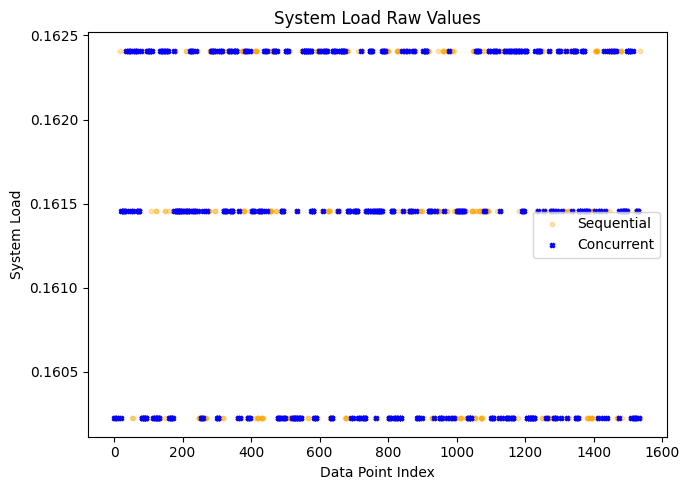

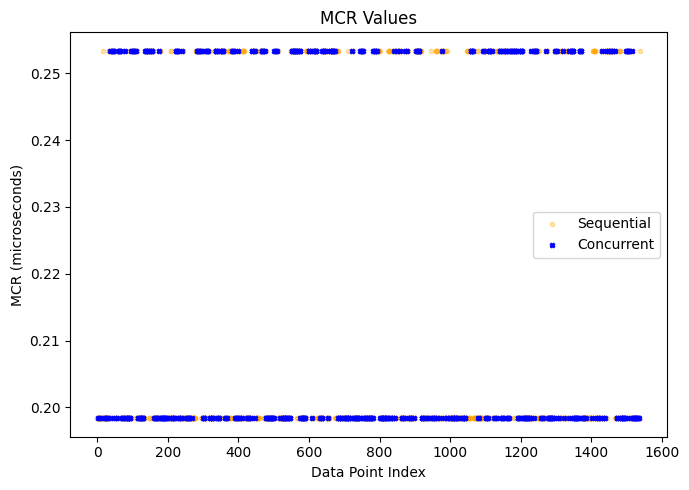

In [21]:
# Figure 1: System Load Raw Values
plt.figure(figsize=(7, 5))

# Plot sequential first (so concurrent will be on top)
plt.scatter(df_load[df_load['execution_order'] == 'sequential'].index, 
           sequential_load, label='Sequential', alpha=0.3, c='orange', s=10)
# Plot concurrent with larger, more opaque points
plt.scatter(df_load[df_load['execution_order'] == 'concurrent'].index, 
           concurrent_load, label='Concurrent', alpha=1.0, c='blue', s=10, marker='X')
plt.title("System Load Raw Values")
plt.xlabel("Data Point Index")
plt.ylabel("System Load")
plt.legend()
plt.tight_layout()
plt.savefig('system_load_plot.png', dpi=300)
plt.show()

# Figure 2: MCR Values
plt.figure(figsize=(7, 5))
plt.scatter(df_mcr[df_mcr['execution_order'] == 'sequential'].index, 
           sequential_mcr * 10**6, label='Sequential', alpha=0.3, c='orange', s=10)
plt.scatter(df_mcr[df_mcr['execution_order'] == 'concurrent'].index, 
           concurrent_mcr * 10**6, label='Concurrent', alpha=1.0, c='blue', s=10, marker='X')
plt.title("MCR Values")
plt.xlabel("Data Point Index")
plt.ylabel("MCR (microseconds)")
plt.legend()
plt.tight_layout()
plt.savefig('mcr_plot.png', dpi=300)
plt.show()

## Chi-square test to determine if um matters in execution order

Mixed Pattern with Significant Concurrency
- **File**: `sibling_MS_30541_MS_3533.csv`
- **Observations**: 11,776 (760 concurrent, 11,016 sequential)

In [18]:
from scipy.stats import chi2_contingency

# Load the CSV file
df = pd.read_csv("sibling-for-analysis/sibling_MS_30541_MS_3533.csv")  # Replace with actual path

# Create contingency table: counts of execution_order per um
contingency = pd.crosstab(df['um'], df['execution_order'])

# Optional: Filter out UM groups with too few total observations (< 10)
contingency['total'] = contingency.sum(axis=1)
contingency = contingency[contingency['total'] >= 10].drop(columns='total')

print("Filtered Contingency Table:")
print(contingency)

# Check if table still valid for test
if contingency.shape[0] < 2 or contingency.shape[1] < 2:
    print("\nNot enough data to run Chi-square test after filtering.")
else:
    # Run chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency)

    # Print results
    print(f"\nChi-square statistic: {chi2:.4f}")
    print(f"Degrees of freedom: {dof}")
    print(f"p-value: {p:.4e}")

    # Show expected frequencies
    expected_df = pd.DataFrame(expected, index=contingency.index, columns=contingency.columns)
    print("\nExpected Frequencies:")
    print(expected_df.round(2))

    # Interpret result
    if p < 0.05:
        print("\nConclusion: There is a statistically significant association between `um` and `execution_order`.")
    else:
        print("\nConclusion: No significant association between `um` and `execution_order`.")

Filtered Contingency Table:
execution_order  concurrent  sequential
um                                     
MS_29421                  4         910
MS_31205                  0         260
MS_45073                  0          22
MS_52394                232        8627
MS_60503                  4         151
MS_9638                 514        1024

Chi-square statistic: 2157.4855
Degrees of freedom: 5
p-value: 0.0000e+00

Expected Frequencies:
execution_order  concurrent  sequential
um                                     
MS_29421              58.66      855.34
MS_31205              16.69      243.31
MS_45073               1.41       20.59
MS_52394             568.58     8290.42
MS_60503               9.95      145.05
MS_9638               98.71     1439.29

Conclusion: There is a statistically significant association between `um` and `execution_order`.


✅ Validity:
	•	All row totals ≥ 10: We’ve dropped low-frequency um groups, so small sample bias is avoided.
	•	No zero-expected counts: Even if some observed counts are 0, expected counts are non-zero and large enough due to other values in the row/column.
	•	Sufficient total sample size: The overall number of observations is large enough to justify using the chi-square approximation.

🔍 Interpretation of Results:
	•	Chi-square statistic: 2157.49
	•	Degrees of freedom: 5 (number of um categories - 1)
	•	p-value: 0.0000 → extremely small

Conclusion: There is **strong evidence of an association** between the upstream microservice (um) and the execution order (sequential vs. concurrent). In other words, which um is involved seems to influence how its downstream services are executed.

MS_9638                 514        1024

run logistic regression to determine 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

def calculate_system_load(filtered):
    filtered['dm1_system_load'] = 0.7 * filtered['dm1_cpu'] + 0.3 * filtered['dm1_memory']
    return filtered

def regression_analysis(csv_path):
    print(f"Running regression analysis on {csv_path} ...")
    df = pd.read_csv(csv_path)

    df['dm1_cpu'] = pd.to_numeric(df['dm1_cpu'], errors='coerce')
    df['dm1_memory'] = pd.to_numeric(df['dm1_memory'], errors='coerce')
    df['dm1_mcr'] = pd.to_numeric(df['dm1_mcr'], errors='coerce')
    df['dm1_system_load'] = 0.7 * df['dm1_cpu'] + 0.3 * df['dm1_memory']
    # Convert lag columns and calculate their average
    df['dm1_system_lag'] = pd.to_numeric(df['dm1_system_lag'], errors='coerce')
    df['dm1_mcr_lag'] = pd.to_numeric(df['dm1_mcr_lag'], errors='coerce')
    # df['dm1_avg_lag'] = df[['dm1_system_lag', 'dm1_mcr_lag']].mean(axis=1)

    regression_data = df[df[['dm1_system_load', 'dm1_mcr']].notna().all(axis=1)].copy()

    if regression_data.empty:
        print("No valid rows for regression.")
        return

    if regression_data['execution_order'].dtype == object:
        y = pd.Categorical(regression_data['execution_order']).codes
    else:
        y = regression_data['execution_order'].values

    X = regression_data[['dm1_system_load', 'dm1_mcr']].values

    model = LogisticRegression()
    model.fit(X, y)

    print("\n===== Logistic Regression Results =====")
    print(f"Intercept: {model.intercept_[0]:.4f}")
    print(f"Coefficient for dm1_system_load: {model.coef_[0][0]:.4f}")
    print(f"Coefficient for dm1_mcr: {model.coef_[0][1]:.4e}")
    print(f"Accuracy (R² Score): {model.score(X, y):.4f}")

    # Odds ratios
    odds_ratios = np.exp(model.coef_[0])
    print(f"\nOdds Ratio for dm1_system_load: {odds_ratios[0]:.4f}")
    print(f"Odds Ratio for dm1_mcr: {odds_ratios[1]:.4f}")
    print("=======================================\n")

    # Print average and std for lag columns
    print(f"\nAvg dm1_system_lag: {regression_data['dm1_system_lag'].mean():.4f} ± {regression_data['dm1_system_lag'].std():.4f}")
    print(f"Avg dm1_mcr_lag: {regression_data['dm1_mcr_lag'].mean():.4f} ± {regression_data['dm1_mcr_lag'].std():.4f}")
    return model, X, y
    # print(f"Avg dm1_avg_lag: {regression_data['dm1_avg_lag'].mean():.4f} ± {regression_data['dm1_avg_lag'].std():.4f}")

# if __name__ == "__main__":
#     # Replace with your actual CSV path or pass it dynamically
#     regression_analysis("output/contextual_MS_9638.csv")
    # regression_analysis("output/contextual_MS_52394.csv")

Running regression analysis on output/contextual_MS_9638.csv ...

===== Logistic Regression Results =====
Intercept: 0.6718
Coefficient for dm1_system_load: 0.1075
Coefficient for dm1_mcr: 1.4389e-07
Accuracy (R² Score): 0.6658

Odds Ratio for dm1_system_load: 1.1135
Odds Ratio for dm1_mcr: 1.0000


Avg dm1_system_lag: 28717.6313 ± 17620.4911
Avg dm1_mcr_lag: 28717.6313 ± 17620.4911


Running regression analysis on output/contextual_MS_9638.csv ...
Detected sequential/concurrent execution order - converting to binary
Category mapping: {'sequential': 0, 'concurrent': 1}
Target variable has 2 classes
Using binary logistic regression with sequential=0, concurrent=1

===== Logistic Regression Results =====
Training Accuracy: 0.4666
Testing Accuracy: 0.4156
Cross-validation Accuracy: 0.4721 ± 0.0347

Model Parameters:
Intercept: 0.0008
Coefficient for dm1_system_load: -0.1267 (Odds Ratio: 0.8810)
Coefficient for dm1_mcr: 0.1546 (Odds Ratio: 1.1671)

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.29      0.39       256
           1       0.32      0.67      0.44       129

    accuracy                           0.42       385
   macro avg       0.48      0.48      0.41       385
weighted avg       0.53      0.42      0.41       385


Confusion Matrix:
[[ 73 183]
 [ 42  87]]

Lag Statistics:
Avg dm1_system_lag: 

/Users/Wanda/Desktop/siblings/myenv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Wanda/Desktop/siblings/myenv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Wanda/Desktop/siblings/myenv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/Wanda/Desktop/siblings/myenv/lib/python3.13/site-packages/sklea

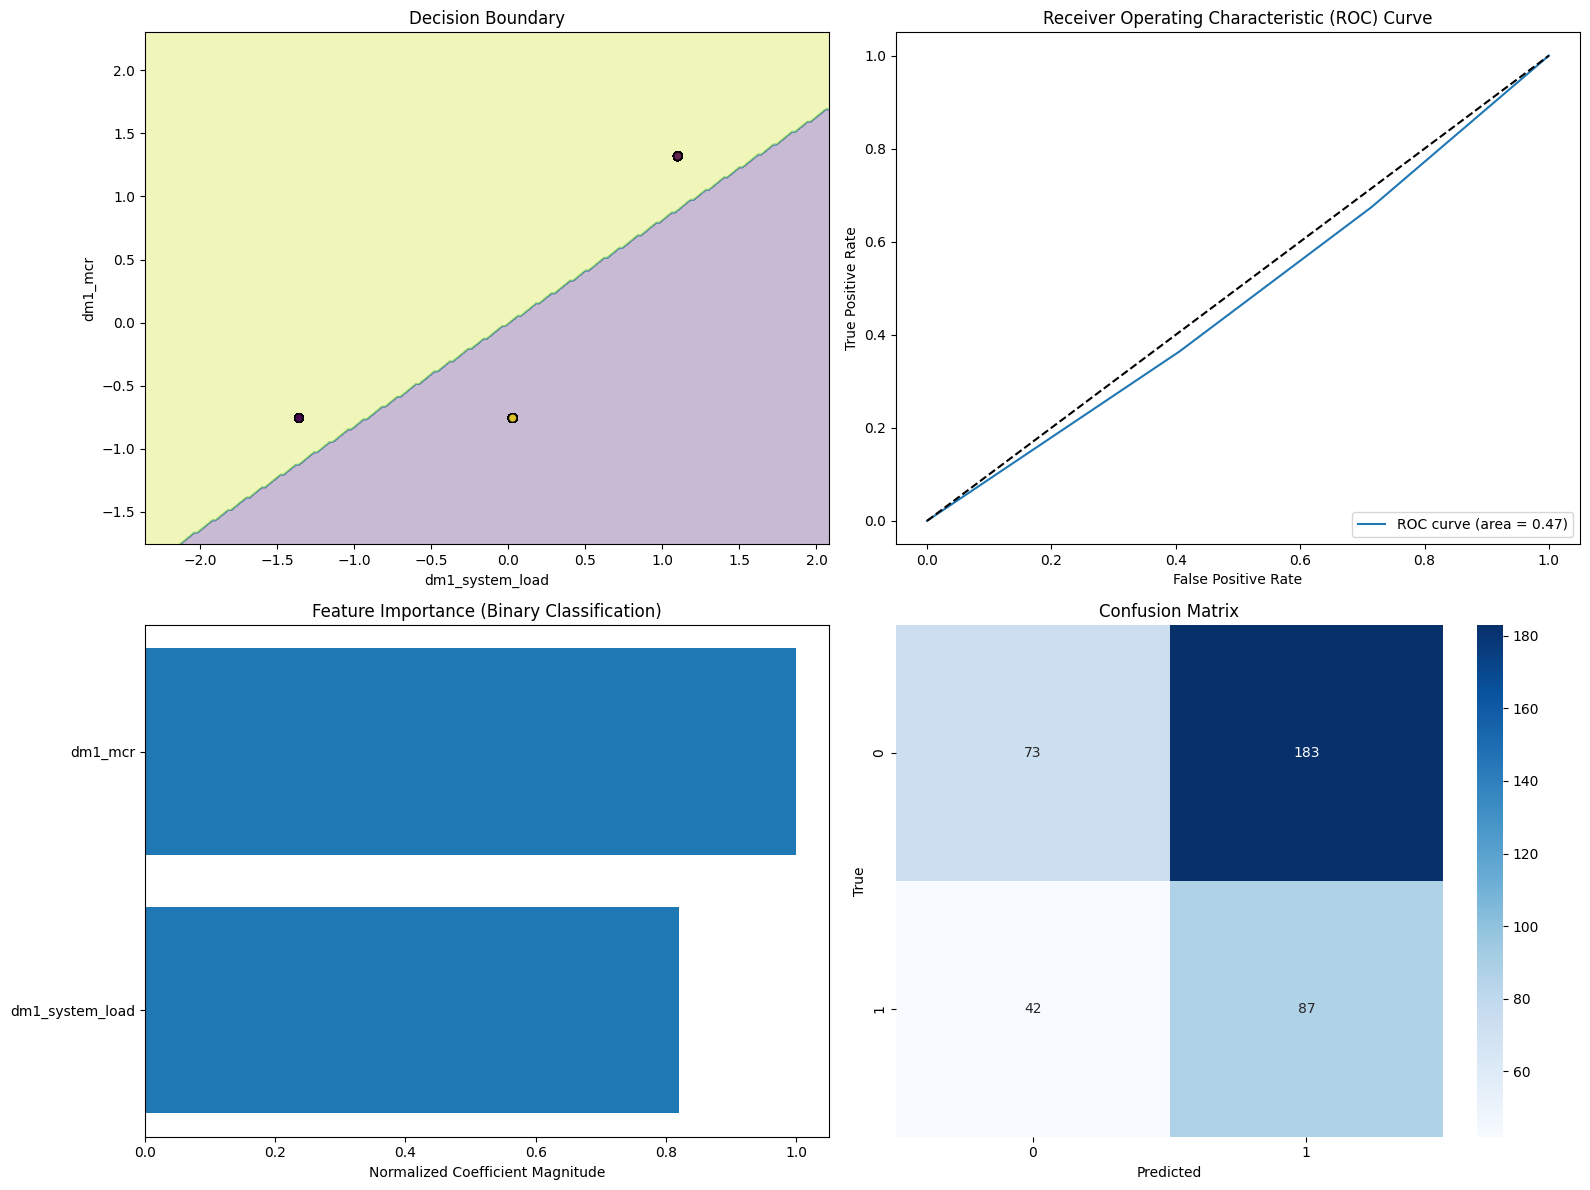

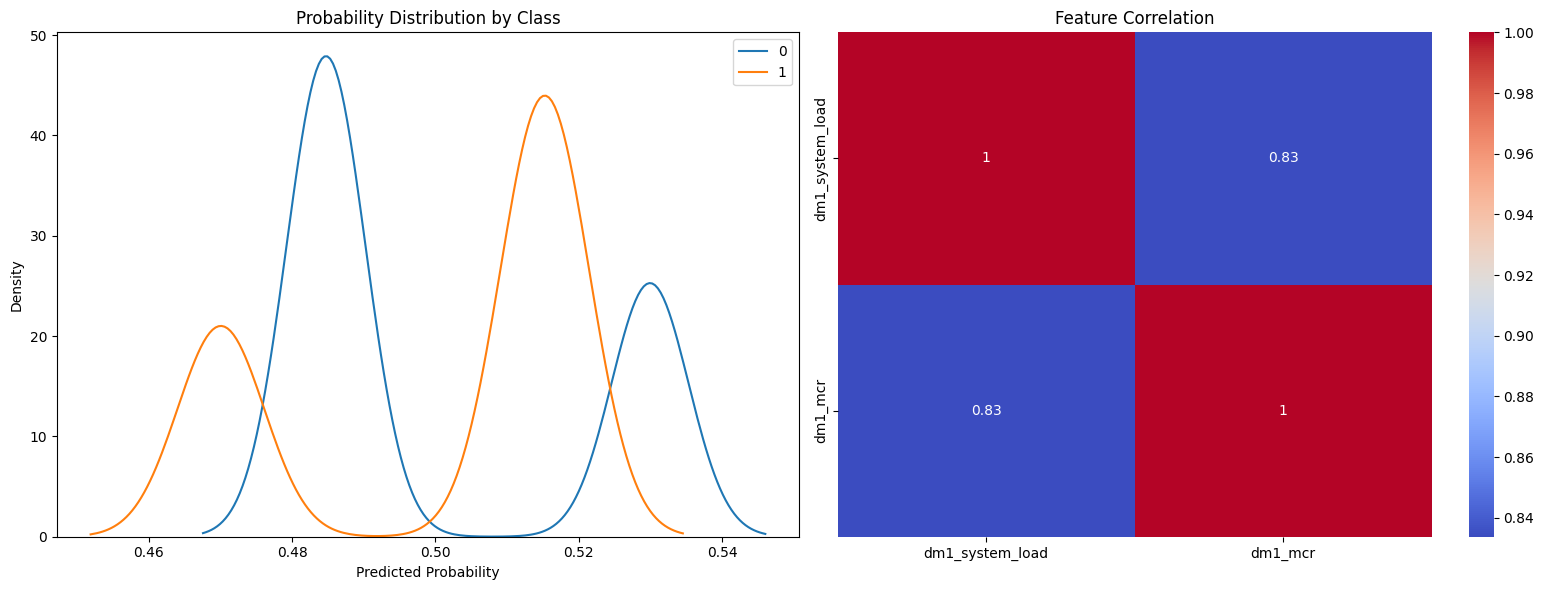

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

def regression_analysis(csv_path, test_size=0.25, random_state=42):
    """
    Performs logistic regression analysis on the given CSV file with improved
    preprocessing, validation, and visualization.
    
    This version properly handles binary encoding of execution_order, with
    'sequential' mapped to 0 and 'concurrent' mapped to 1 to ensure proper
    model evaluation and interpretation.
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file
    test_size : float, optional (default=0.25)
        Proportion of data to use for testing
    random_state : int, optional (default=42)
        Random seed for reproducibility
    
    Returns:
    --------
    tuple
        (model, X, y, X_train, X_test, y_train, y_test, feature_names, scaler)
    """
    print(f"Running regression analysis on {csv_path} ...")
    
    # Load and preprocess data
    df = pd.read_csv(csv_path)
    
    # Convert numeric columns with error handling
    numeric_cols = ['dm1_cpu', 'dm1_memory', 'dm1_mcr', 'dm1_system_lag', 'dm1_mcr_lag']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Calculate system load
    df['dm1_system_load'] = 0.7 * df['dm1_cpu'] + 0.3 * df['dm1_memory']
    
    # Calculate average lag (optional - uncomment if needed)
    # df['dm1_avg_lag'] = df[['dm1_system_lag', 'dm1_mcr_lag']].mean(axis=1)
    
    # Feature columns to use in the model
    feature_cols = ['dm1_system_load', 'dm1_mcr']
    
    # Drop rows with missing values in feature or target columns
    regression_data = df.dropna(subset=feature_cols + ['execution_order']).copy()
    
    if regression_data.empty:
        print("No valid rows for regression.")
        return None
    
    # Explicitly convert execution_order to binary encoding
    if 'sequential' in regression_data['execution_order'].values or 'concurrent' in regression_data['execution_order'].values:
        # Use explicit binary mapping for sequential/concurrent
        print("Detected sequential/concurrent execution order - converting to binary")
        category_mapping = {'sequential': 0, 'concurrent': 1}
        y = regression_data['execution_order'].map(category_mapping).values
        print(f"Category mapping: {category_mapping}")
        num_classes = 2
    elif regression_data['execution_order'].dtype == object:
        # For other categorical values, map to integers and store the mapping
        categories = regression_data['execution_order'].unique()
        category_mapping = {cat: i for i, cat in enumerate(categories)}
        y = regression_data['execution_order'].map(category_mapping).values
        print(f"Category mapping: {category_mapping}")
        num_classes = len(categories)
    else:
        # For numeric values, use as-is
        y = regression_data['execution_order'].values
        num_classes = len(np.unique(y))
        print(f"Using numeric execution_order with {num_classes} unique values")
    
    print(f"Target variable has {num_classes} classes")
    
    # Get feature matrix
    X = regression_data[feature_cols].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Initialize and fit the model
    # For binary classification (sequential vs concurrent), we use specific settings
    solver = 'liblinear'  # Better solver for binary classification
    multi_class = 'auto'  # Let sklearn decide based on the data
    
    if num_classes > 2:
        print("Using multinomial logistic regression (multi-class classification)")
        solver = 'lbfgs'  # Better solver for multi-class
        multi_class = 'multinomial'
    else:
        print("Using binary logistic regression with sequential=0, concurrent=1")
    
    model = LogisticRegression(
        solver=solver,
        multi_class=multi_class,
        max_iter=1000,
        random_state=random_state,
            class_weight='balanced'  # This automatically calculates appropriate weights
    )
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    cv_scores = cross_val_score(model, X_scaled, y, cv=5)
    
    print("\n===== Logistic Regression Results =====")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Print coefficients and odds ratios
    print("\nModel Parameters:")
    if num_classes == 2:
        # Binary classification case
        print(f"Intercept: {model.intercept_[0]:.4f}")
        for i, feature in enumerate(feature_cols):
            coef = model.coef_[0][i]
            odds_ratio = np.exp(coef)
            print(f"Coefficient for {feature}: {coef:.4f} (Odds Ratio: {odds_ratio:.4f})")
    else:
        # Multi-class case
        for class_idx in range(num_classes):
            if hasattr(model, 'classes_'):
                class_name = model.classes_[class_idx]
                print(f"\nClass: {class_name}")
            else:
                print(f"\nClass {class_idx}:")
                
            if len(model.intercept_) > class_idx:
                print(f"Intercept: {model.intercept_[class_idx]:.4f}")
                
            if model.coef_.shape[0] > class_idx:
                for i, feature in enumerate(feature_cols):
                    coef = model.coef_[class_idx][i]
                    odds_ratio = np.exp(coef)
                    print(f"Coefficient for {feature}: {coef:.4f} (Odds Ratio: {odds_ratio:.4f})")
    
    # Print classification report
    y_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Lag statistics
    print("\nLag Statistics:")
    lag_cols = ['dm1_system_lag', 'dm1_mcr_lag']
    for col in lag_cols:
        if col in regression_data.columns:
            print(f"Avg {col}: {regression_data[col].mean():.4f} ± {regression_data[col].std():.4f}")
    
    print("=======================================\n")
    
    return (model, X_scaled, y, X_train, X_test, y_train, y_test, 
            feature_cols, scaler, regression_data[feature_cols], num_classes)

def plot_decision_boundary(model, X, y, feature_names, class_names=None, ax=None):
    """
    Plot the decision boundary for a logistic regression model with two features.
    
    Parameters:
    -----------
    model : sklearn model
        Trained logistic regression model
    X : array-like
        Feature matrix (must have exactly 2 features)
    y : array-like
        Target variable
    feature_names : list
        Names of the features
    class_names : list, optional
        Names of the classes
    ax : matplotlib axis, optional
        Axis to plot on
    
    Returns:
    --------
    matplotlib axis
    """
    if X.shape[1] != 2:
        raise ValueError("This function only works for models with exactly 2 features")
    
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 8))
    
    # Create a mesh grid for plotting the decision boundary
    h = 0.02  # step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Get predictions for the entire mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3)
    
    # Plot the data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', alpha=0.8)
    
    # Add a legend
    if class_names is not None:
        legend1 = ax.legend(*scatter.legend_elements(),
                           loc="upper right", title="Classes")
        ax.add_artist(legend1)
    
    # Label the axes
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title('Decision Boundary')
    
    return ax

def plot_roc_curve(model, X_test, y_test, num_classes, ax=None):
    """
    Plot ROC curve for the logistic regression model.
    
    Parameters:
    -----------
    model : sklearn model
        Trained logistic regression model
    X_test : array-like
        Test feature matrix
    y_test : array-like
        Test target variable
    num_classes : int
        Number of classes
    ax : matplotlib axis, optional
        Axis to plot on
    
    Returns:
    --------
    matplotlib axis
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    
    if num_classes == 2:
        # Binary classification case
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    else:
        # Multi-class case - plot for each class (one-vs-rest)
        y_test_bin = np.zeros((y_test.size, num_classes))
        for i in range(num_classes):
            y_test_bin[:, i] = (y_test == i).astype(int)
        
        y_pred_proba = model.predict_proba(X_test)
        
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, label=f'Class {model.classes_[i] if hasattr(model, "classes_") else i} (area = {roc_auc:.2f})')
    
    # Add diagonal line representing random guessing
    ax.plot([0, 1], [0, 1], 'k--')
    
    # Labels and title
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc="lower right")
    
    return ax

def plot_feature_importance(model, feature_names, num_classes, ax=None):
    """
    Plot feature importance for the logistic regression model.
    
    Parameters:
    -----------
    model : sklearn model
        Trained logistic regression model
    feature_names : list
        Names of the features
    num_classes : int
        Number of classes
    ax : matplotlib axis, optional
        Axis to plot on
    
    Returns:
    --------
    matplotlib axis
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))
    
    if num_classes == 2:
        # Binary classification case
        importance = np.abs(model.coef_[0])
        importance /= importance.max()  # Normalize
        
        # Sort by importance
        sorted_idx = importance.argsort()
        pos = np.arange(sorted_idx.shape[0])
        
        ax.barh(pos, importance[sorted_idx], align='center')
        ax.set_yticks(pos)
        ax.set_yticklabels([feature_names[i] for i in sorted_idx])
        ax.set_title('Feature Importance (Binary Classification)')
    else:
        # Multi-class case
        importance = np.abs(model.coef_)
        
        # Sort by mean importance across classes
        mean_importance = np.mean(importance, axis=0)
        sorted_idx = mean_importance.argsort()
        pos = np.arange(sorted_idx.shape[0])
        
        for i in range(num_classes):
            if i == 0:
                bottom = None
            else:
                bottom = np.sum(importance[:i, sorted_idx], axis=0)
            
            class_name = model.classes_[i] if hasattr(model, "classes_") else f"Class {i}"
            ax.barh(pos, importance[i, sorted_idx], left=bottom, align='center', 
                   label=f'{class_name}')
        
        ax.set_yticks(pos)
        ax.set_yticklabels([feature_names[i] for i in sorted_idx])
        ax.set_title('Feature Importance by Class')
        ax.legend(loc="lower right")
    
    ax.set_xlabel('Normalized Coefficient Magnitude')
    
    return ax

def plot_probability_distribution(model, X, y, ax=None):
    """
    Plot probability distribution for each class.
    
    Parameters:
    -----------
    model : sklearn model
        Trained logistic regression model
    X : array-like
        Feature matrix
    y : array-like
        Target variable
    ax : matplotlib axis, optional
        Axis to plot on
    
    Returns:
    --------
    matplotlib axis
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))
    
    # Get probabilities
    probas = model.predict_proba(X)
    
    # Plot probability distribution for each class
    for i in range(probas.shape[1]):
        if hasattr(model, 'classes_'):
            class_name = model.classes_[i]
        else:
            class_name = f"Class {i}"
        
        # Plot only probabilities for data points belonging to this class
        class_probas = probas[y == i, i]
        
        if len(class_probas) > 0:
            sns.kdeplot(class_probas, ax=ax, label=f'{class_name}')
    
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Density')
    ax.set_title('Probability Distribution by Class')
    ax.legend()
    
    return ax

def plot_confusion_matrix(y_test, y_pred, class_names=None, ax=None):
    """
    Plot confusion matrix.
    
    Parameters:
    -----------
    y_test : array-like
        True target values
    y_pred : array-like
        Predicted target values
    class_names : list, optional
        Names of the classes
    ax : matplotlib axis, optional
        Axis to plot on
    
    Returns:
    --------
    matplotlib axis
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    
    if class_names is not None:
        ax.set_xticklabels(class_names)
        ax.set_yticklabels(class_names)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    
    return ax

def create_visualization_plots(result_tuple):
    """
    Create various visualization plots for the logistic regression model.
    
    Parameters:
    -----------
    result_tuple : tuple
        Result tuple from regression_analysis function
    
    Returns:
    --------
    matplotlib figure
    """
    model, X, y, X_train, X_test, y_train, y_test, feature_names, scaler, X_orig, num_classes = result_tuple
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot decision boundary (only if we have exactly 2 features)
    if X.shape[1] == 2:
        plot_decision_boundary(model, X, y, feature_names, ax=axes[0, 0])
    else:
        axes[0, 0].text(0.5, 0.5, "Decision boundary requires exactly 2 features",
                       ha='center', va='center')
        axes[0, 0].set_title("Decision Boundary (Not Available)")
    
    # Plot ROC curve
    plot_roc_curve(model, X_test, y_test, num_classes, ax=axes[0, 1])
    
    # Plot feature importance
    plot_feature_importance(model, feature_names, num_classes, ax=axes[1, 0])
    
    # Plot confusion matrix
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, ax=axes[1, 1])
    
    # Adjust layout
    plt.tight_layout()
    
    # Create second figure for additional plots
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot probability distribution
    plot_probability_distribution(model, X, y, ax=axes2[0])
    
    # Plot feature correlation
    if isinstance(X_orig, pd.DataFrame):
        sns.heatmap(X_orig.corr(), annot=True, cmap='coolwarm', ax=axes2[1])
        axes2[1].set_title('Feature Correlation')
    else:
        axes2[1].text(0.5, 0.5, "Feature correlation requires DataFrame input",
                     ha='center', va='center')
        axes2[1].set_title("Feature Correlation (Not Available)")
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, fig2

def run_analysis_and_visualization(csv_path):
    """
    Run the full analysis and visualization pipeline.
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file
    
    Returns:
    --------
    tuple
        (model, visualization figures)
    """
    # Run regression analysis
    result_tuple = regression_analysis(csv_path)
    
    if result_tuple is None:
        print("Analysis failed - no valid data")
        return None, None, None
    
    # Create visualization plots
    fig1, fig2 = create_visualization_plots(result_tuple)
    
    return result_tuple[0], fig1, fig2

if __name__ == "__main__":
    # Replace with your actual CSV path or pass it dynamically
    csv_path = "output/contextual_MS_9638.csv"
    model, fig1, fig2 = run_analysis_and_visualization(csv_path)
    
    if fig1 is not None and fig2 is not None:
        fig1.savefig("logistic_regression_visualizations1.png")
        fig2.savefig("logistic_regression_visualizations2.png")
        plt.show()

In [49]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def regression_analysis(csv_path):
    print(f"📊 Running logistic regression on: {csv_path}\n")

    df = pd.read_csv(csv_path)

    # Ensure numeric conversion
    df['dm1_cpu'] = pd.to_numeric(df['dm1_cpu'], errors='coerce')
    df['dm1_memory'] = pd.to_numeric(df['dm1_memory'], errors='coerce')
    df['dm1_mcr'] = pd.to_numeric(df['dm1_mcr'], errors='coerce')
    df['dm1_system_lag'] = pd.to_numeric(df['dm1_system_lag'], errors='coerce')
    df['dm1_mcr_lag'] = pd.to_numeric(df['dm1_mcr_lag'], errors='coerce')

    # Compute weighted system load
    df['dm1_system_load'] = 0.7 * df['dm1_cpu'] + 0.3 * df['dm1_memory']

    # Drop rows with missing values
    regression_data = df.dropna(subset=['dm1_system_load', 'dm1_mcr', 'execution_order'])

    if regression_data.empty:
        print("⚠️ No valid rows for regression.")
        return

    # Encode target variable
    if regression_data['execution_order'].dtype == object:
        y = pd.Categorical(regression_data['execution_order']).codes
    else:
        y = regression_data['execution_order'].values

    # Skip if only one class
    if len(np.unique(y)) < 2:
        print("⚠️ Only one class present. Skipping regression.")
        return

    # Prepare features
    X = regression_data[['dm1_system_load', 'dm1_mcr']].values

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit logistic regression
    model = LogisticRegression()
    model.fit(X_scaled, y)

    # Report
    print("===== Logistic Regression Results =====")
    print(f"Intercept: {model.intercept_[0]:.4f}")
    print(f"Coefficient for dm1_system_load: {model.coef_[0][0]:.4f}")
    print(f"Coefficient for dm1_mcr: {model.coef_[0][1]:.4e}")
    print(f"Accuracy (on training data): {model.score(X_scaled, y):.4f}")

    # Odds ratios
    odds_ratios = np.exp(model.coef_[0])
    print(f"\nOdds Ratio for dm1_system_load: {odds_ratios[0]:.4f}")
    print(f"Odds Ratio for dm1_mcr: {odds_ratios[1]:.4f}")
    print("=======================================\n")

    # Lag stats
    print("⏱️ Average Lag Times:")
    print(f"dm1_system_lag: {regression_data['dm1_system_lag'].mean():.4f} ± {regression_data['dm1_system_lag'].std():.4f}")
    print(f"dm1_mcr_lag:    {regression_data['dm1_mcr_lag'].mean():.4f} ± {regression_data['dm1_mcr_lag'].std():.4f}")

# Example usage:
regression_analysis("output/contextual_MS_9638.csv")

📊 Running logistic regression on: output/contextual_MS_9638.csv

===== Logistic Regression Results =====
Intercept: 0.6895
Coefficient for dm1_system_load: 0.0759
Coefficient for dm1_mcr: -7.8535e-02
Accuracy (on training data): 0.6658

Odds Ratio for dm1_system_load: 1.0789
Odds Ratio for dm1_mcr: 0.9245

⏱️ Average Lag Times:
dm1_system_lag: 28717.6313 ± 17620.4911
dm1_mcr_lag:    28717.6313 ± 17620.4911


	•	Neither system load nor MCR significantly influences execution_order (p > 0.05 for both).
	•	The odds ratios are near 1, indicating almost no change in odds when the predictor changes.
	•	The Pseudo R² is tiny (0.00036), meaning your model explains almost none of the variation in execution pattern.

For MS_9638, contextual metrics like system load and MCR don’t help distinguish between sequential and concurrent execution patterns.
	•	Even though your inputs are clean, normalized, and standardized, there’s likely no meaningful relationship between these features and execution style in this case.

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import warnings

def regression_analysis_with_stats(csv_path):
    print(f"📊 Running logistic regression on: {csv_path}\n")
    
    # Load and clean data
    df = pd.read_csv(csv_path)
    numeric_cols = ['dm1_cpu', 'dm1_memory', 'dm1_mcr', 'dm1_system_lag', 'dm1_mcr_lag']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Compute system load
    df['dm1_system_load'] = 0.7 * df['dm1_cpu'] + 0.3 * df['dm1_memory']

    # Convert execution_order to binary
    df['execution_order'] = df['execution_order'].map({'sequential': 0, 'concurrent': 1})

    # Drop missing rows
    regression_data = df.dropna(subset=['dm1_system_load', 'dm1_mcr', 'execution_order'])

    if regression_data['execution_order'].nunique() < 2:
        print("⚠️ Only one class present in execution_order. Skipping regression.")
        return

    # Features and target
    X = regression_data[['dm1_system_load', 'dm1_mcr']]
    y = regression_data['execution_order']

    # Standardize predictors
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = sm.add_constant(X_scaled)  # Add intercept

    # Fit logistic regression model
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = sm.Logit(y, X_scaled)
            result = model.fit(maxiter=100, disp=True)

        print(result.summary())

        # Calculate odds ratios and 95% confidence intervals
        odds_ratios = np.exp(result.params)
        conf_int = result.conf_int()
        conf_int['OR_lower'] = np.exp(conf_int[0])
        conf_int['OR_upper'] = np.exp(conf_int[1])

        print("\n🧮 Odds Ratios with 95% Confidence Intervals:")
        print(pd.concat([odds_ratios, conf_int[['OR_lower', 'OR_upper']]], axis=1)
                .rename(columns={0: 'OR'}))

    except Exception as e:
        print(f"\n❌ Regression failed: {e}")
        return

    # Display descriptive stats for lag features
    print("\n⏱️ Average Lag Times:")
    print(f"dm1_system_lag: {regression_data['dm1_system_lag'].mean():.4f} ± {regression_data['dm1_system_lag'].std():.4f}")
    print(f"dm1_mcr_lag:    {regression_data['dm1_mcr_lag'].mean():.4f} ± {regression_data['dm1_mcr_lag'].std():.4f}")

# Run the analysis
regression_analysis_with_stats("output/contextual_MS_9638.csv")

📊 Running logistic regression on: output/contextual_MS_9638.csv

Optimization terminated successfully.
         Current function value: 0.636886
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:        execution_order   No. Observations:                 1538
Model:                          Logit   Df Residuals:                     1535
Method:                           MLE   Df Model:                            2
Date:                Fri, 09 May 2025   Pseudo R-squ.:               0.0003575
Time:                        11:01:47   Log-Likelihood:                -979.53
converged:                       True   LL-Null:                       -979.88
Covariance Type:            nonrobust   LLR p-value:                    0.7044
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6896      0.054    -12.753